# Online Retail II — Exploration des données

Ce notebook a pour objectif d'explorer le jeu de données **Online Retail II** afin de :

- comprendre la structure et la qualité des données,
- préparer la construction des cohortes, de la segmentation RFM et de la CLV,
- cadrer la future application Streamlit d’aide à la décision marketing.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/nilsg/Desktop/ECE/Data Visualisation/ECE-DataViz-2025/data/raw/online+retail+ii/online_retail_II.xlsx"

df = pd.read_excel(path, engine="openpyxl")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
print("Shape (lignes, colonnes) :", df.shape)
print("\nTypes et nulls :")
df.info()

Shape (lignes, colonnes) : (525461, 8)

Types et nulls :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## Structure générale du dataset

Le dataset contient **525 461 lignes** et **8 colonnes**.  
Il couvre la période du **1er décembre 2009 au 9 décembre 2010**, soit environ un an.

Les colonnes principales sont :
- Invoice : identifiant de facture
- StockCode : code produit
- Description : description du produit
- Quantity : quantité vendue (peut être négative en cas de retour)
- InvoiceDate : date de la transaction
- Price : prix unitaire
- Customer ID : identifiant du client
- Country : pays

Ce volume est suffisant pour une analyse de cohortes et RFM robuste.


In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Invoice,525461.0,28816.0,537434.0,675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,525461,4632,85123A,3516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,522533,4681,WHITE HANGING HEART T-LIGHT HOLDER,3549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,525461.0,NaN,NaN,NaN,10.337667,-9600.0,1.0,3.0,10.0,19152.0,107.42411
InvoiceDate,525461,NaN,NaN,NaN,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-12-09 20:01:00,NaN
Price,525461.0,NaN,NaN,NaN,4.688834,-53594.36,1.25,2.1,4.21,25111.09,146.126914
Customer ID,417534.0,NaN,NaN,NaN,15360.645478,12346.0,13983.0,15311.0,16799.0,18287.0,1680.811316
Country,525461,40,United Kingdom,485852,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
n_rows = len(df)
n_cols = df.shape[1]
n_customers = df["Customer ID"].nunique()
n_countries = df["Country"].nunique()
date_min = df["InvoiceDate"].min()
date_max = df["InvoiceDate"].max()

summary = {
    "Nombre de lignes": n_rows,
    "Nombre de colonnes": n_cols,
    "Nombre de clients uniques": n_customers,
    "Nombre de pays": n_countries,
    "Première date de facture": date_min,
    "Dernière date de facture": date_max
}

summary

{'Nombre de lignes': 525461,
 'Nombre de colonnes': 8,
 'Nombre de clients uniques': 4383,
 'Nombre de pays': 40,
 'Première date de facture': Timestamp('2009-12-01 07:45:00'),
 'Dernière date de facture': Timestamp('2010-12-09 20:01:00')}

## Dictionnaire des variables (version 1)

- **Invoice** : identifiant de facture (chaîne de caractères, peut contenir des retours/annulations).
- **StockCode** : identifiant du produit.
- **Description** : description textuelle du produit.
- **Quantity** : quantité d’articles pour une ligne de facture (peut être négative en cas de retour).
- **InvoiceDate** : date et heure de la facture.
- **Price** : prix unitaire du produit (en monnaie locale, probablement GBP).
- **Customer ID** : identifiant numérique du client.
- **Country** : pays du client.


In [6]:
na_counts = df.isna().sum().sort_values(ascending=False)
na_percent = (na_counts / len(df) * 100).round(2)

na_table = pd.DataFrame({
    "nb_na": na_counts,
    "%_na": na_percent
})

na_table


,nb_na,%_na
Customer ID,107927,20.54
Description,2928,0.56
Invoice,0,0.00
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
Price,0,0.00
Country,0,0.00


## Valeurs manquantes

On observe que :
- **20,5%** des Customer ID sont manquants → impossible de les utiliser pour les analyses client (RFM, cohortes, CLV).
- 0,56% des descriptions sont manquantes → impact négligeable.

Les lignes sans Customer ID seront exclues pour les analyses basées sur le comportement client.

In [7]:
dup_count = df.duplicated().sum()
dup_count

6865

In [8]:
df["Amount"] = df["Quantity"] * df["Price"]
df[["Quantity", "Price", "Amount"]].head()

,Quantity,Price,Amount
0,12,6.95,83.4
1,12,6.75,81.0
2,12,6.75,81.0
3,48,2.10,100.8
4,24,1.25,30.0


In [9]:
print("Quantités négatives :", (df["Quantity"] < 0).sum())
print("Prix négatifs :", (df["Price"] < 0).sum())
print("Montants négatifs :", (df["Amount"] < 0).sum())

Quantités négatives : 12326
Prix négatifs : 3
Montants négatifs : 10208


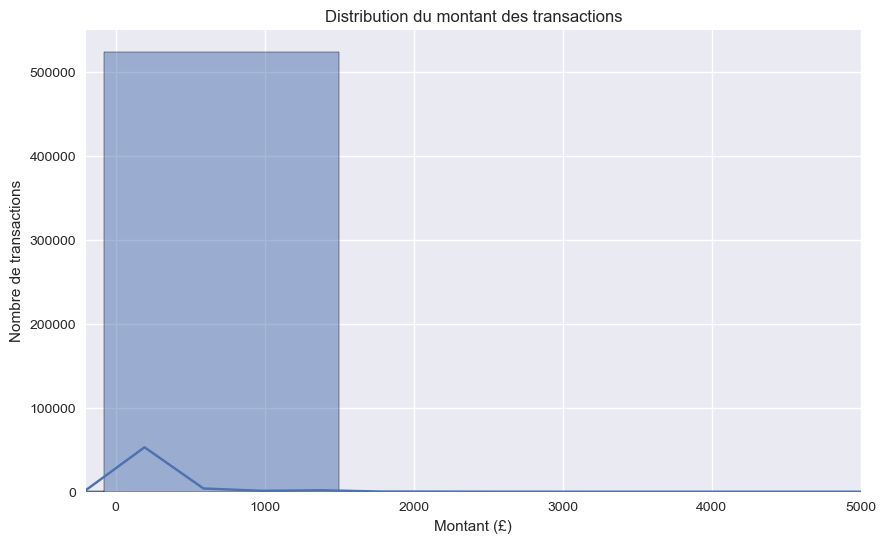

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Distribution du montant des transactions")
plt.xlabel("Montant (£)")
plt.ylabel("Nombre de transactions")
plt.xlim(-200, 5000)  # pour retirer les extrêmes
plt.show()

## Distribution des montants

La distribution des montants montre une forte concentration entre 0 et 50 £, 
avec quelques valeurs extrêmes. Les valeurs négatives correspondent aux retours.

Ce graphique permet d'évaluer la dispersion et d'anticiper le choix de seuils
pour les analyses (RFM, scénarios de marge, etc.).


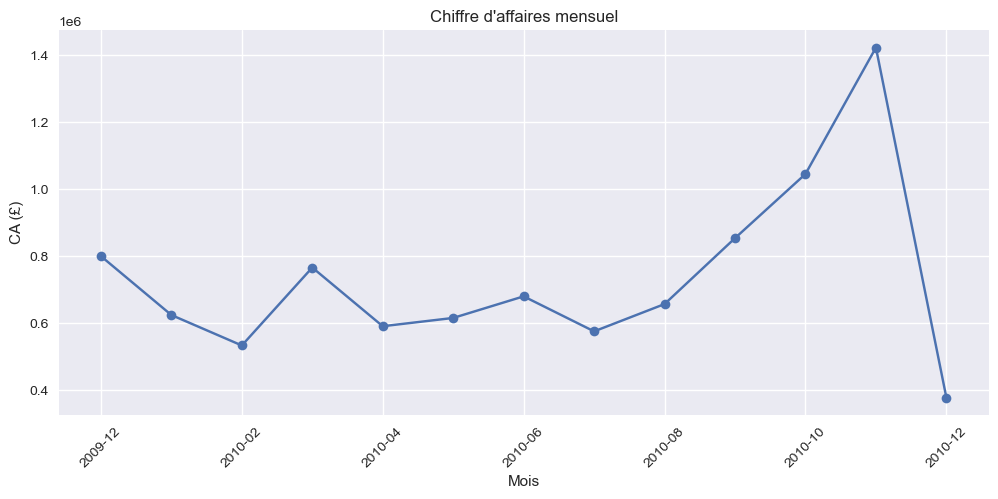

In [11]:
df["Month"] = df["InvoiceDate"].dt.to_period("M").astype(str)

monthly_sales = df.groupby("Month")["Amount"].sum()

plt.figure(figsize=(12,5))
monthly_sales.plot(kind="line", marker="o")
plt.title("Chiffre d'affaires mensuel")
plt.xlabel("Mois")
plt.ylabel("CA (£)")
plt.xticks(rotation=45)
plt.show()


## Chiffre d'affaires par mois

On observe une forte saisonnalité, avec un pic autour de novembre-décembre, 
période classique d'intensification des ventes e-commerce.

Cette visualisation valide la pertinence de travailler au niveau mensuel pour
les cohortes d'acquisition.

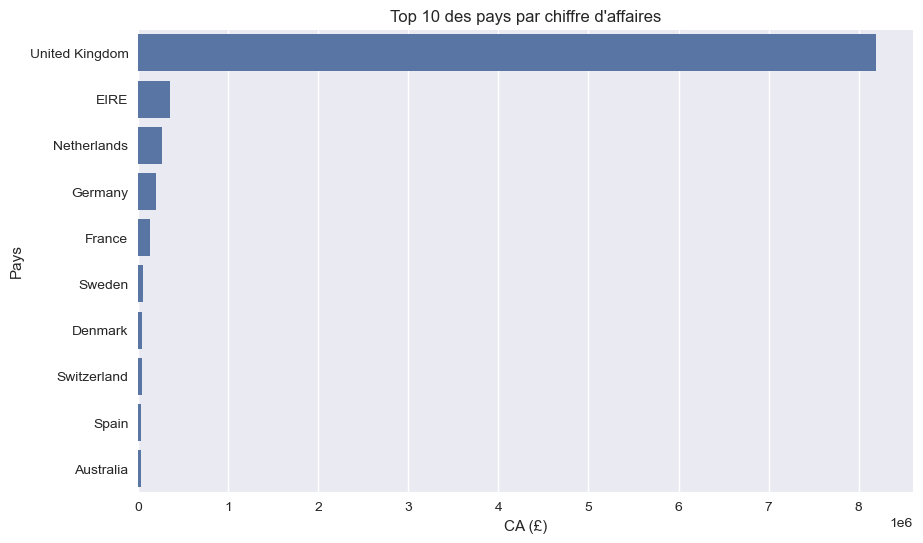

In [12]:
country_sales = df.groupby("Country")["Amount"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title("Top 10 des pays par chiffre d'affaires")
plt.xlabel("CA (£)")
plt.ylabel("Pays")
plt.show()


## CA par pays

Le Royaume-Uni représente largement la majorité des ventes, ce qui est cohérent
avec un retailer principalement britannique. Les autres pays contribuent beaucoup
moins, mais restent importants pour identifier des segments à potentiel.


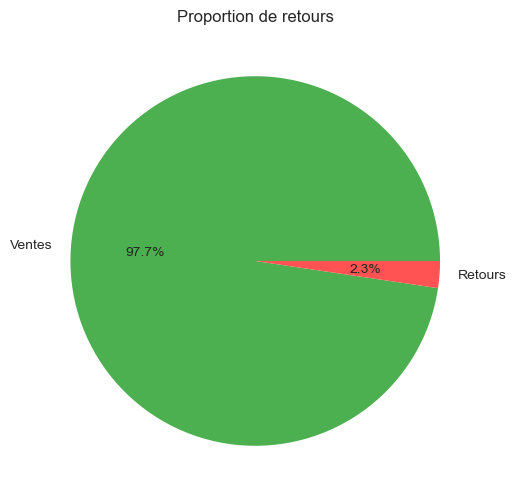

In [13]:
df["IsReturn"] = df["Quantity"] < 0

plt.figure(figsize=(6,6))
df["IsReturn"].value_counts().plot(kind="pie", autopct="%1.1f%%", labels=["Ventes", "Retours"], colors=["#4CAF50","#FF5252"])
plt.title("Proportion de retours")
plt.ylabel("")
plt.show()


## Proportion de retours

Environ 2% des lignes de transaction sont des retours.  
Ces retours auront un impact direct sur les cohortes, la marge et la CLV.

La future application Streamlit devra permettre de les inclure, exclure ou neutraliser.

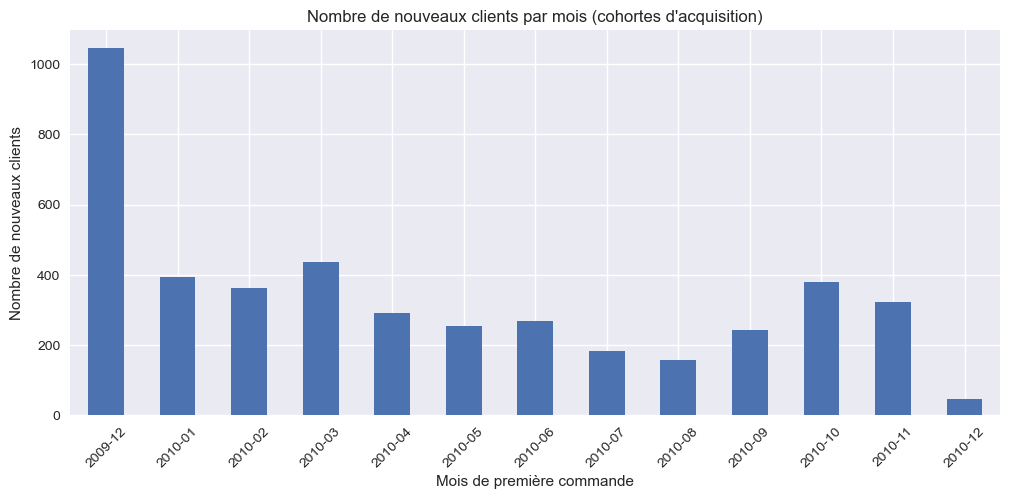

In [14]:
df["CohortMonth"] = df["InvoiceDate"].dt.to_period("M")
df["CustomerFirstPurchase"] = df.groupby("Customer ID")["InvoiceDate"].transform("min").dt.to_period("M")

cohort_counts = df.groupby(["CustomerFirstPurchase"])["Customer ID"].nunique()

plt.figure(figsize=(12,5))
cohort_counts.plot(kind="bar")
plt.title("Nombre de nouveaux clients par mois (cohortes d'acquisition)")
plt.xlabel("Mois de première commande")
plt.ylabel("Nombre de nouveaux clients")
plt.xticks(rotation=45)
plt.show()


## Premiers aperçus des cohortes d'acquisition

Ce graphique montre combien de nouveaux clients ont été acquis chaque mois.  
Il permet d'identifier les pics d'acquisition et constituera la base de la heatmap
de rétention dans l'application Streamlit.


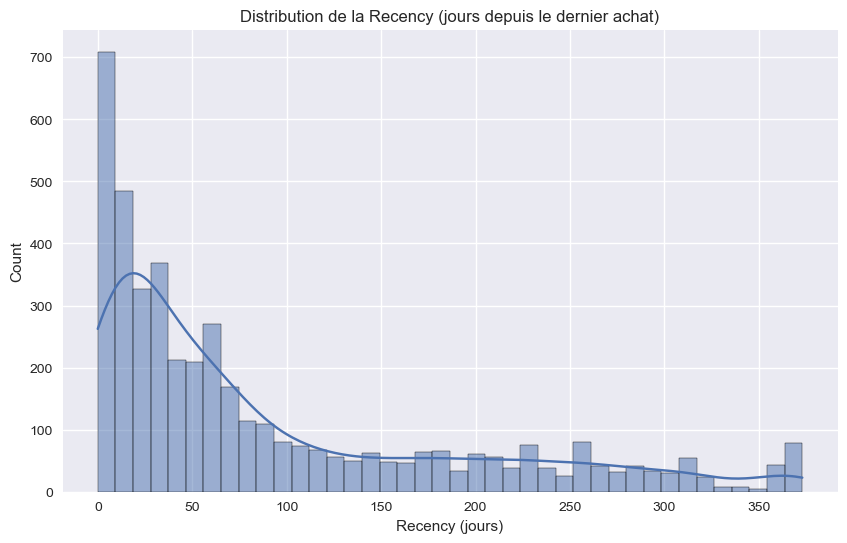

In [15]:
max_date = df["InvoiceDate"].max()
rfm = df[df["Customer ID"].notna()].groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (max_date - x.max()).days,
    "Invoice": "count",
    "Amount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

plt.figure(figsize=(10,6))
sns.histplot(rfm["Recency"], kde=True, bins=40)
plt.title("Distribution de la Recency (jours depuis le dernier achat)")
plt.xlabel("Recency (jours)")
plt.show()


## Premier aperçu RFM : Recency

La recency donne la durée depuis la dernière commande d'un client.  
Une forte concentration vers 0 signifie que beaucoup de clients sont récents, 
tandis qu'une longue traîne vers la droite indique une réactivation faible.

Ces observations guideront la segmentation RFM.


## Nettoyage du jeu de données

Nous appliquons ici un nettoyage professionnel pour préparer toutes les analyses (cohortes, RFM, CLV).

Objectifs :
- isoler les retours (quantités négatives),
- supprimer les valeurs inutilisables (NA critiques),
- retirer les doublons,
- créer un dataset propre `df_clean`,
- ajouter des variables dérivées utiles (mois, année, cohorte),
- préparer les scénarios Streamlit (flag retours).


In [16]:
df_clean = df.dropna(subset=["Customer ID"]).copy()
print("Lignes restantes :", len(df_clean))

Lignes restantes : 417534


Supprimer les doublons

In [17]:
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print("Doublons supprimés :", before - len(df_clean))


Doublons supprimés : 6771


Création d’un flag “Retour”
On ne supprime pas les retours : on les tag, car l’utilisateur de l'app doit pouvoir :

inclure les retours

exclure les retours

neutraliser l’impact sur le CA

In [18]:
df_clean["IsReturn"] = df_clean["Quantity"] < 0
df_clean["IsReturn"].value_counts()

IsReturn
False    400947
True       9816
Name: count, dtype: int64

Montant corrigé (toujours positif)

In [19]:
df_clean["Amount"] = df_clean["Quantity"] * df_clean["Price"]
df_clean["AmountAbs"] = df_clean["Amount"].abs()

Nettoyage des dates

In [20]:
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])
df_clean["InvoiceYear"] = df_clean["InvoiceDate"].dt.year
df_clean["InvoiceMonth"] = df_clean["InvoiceDate"].dt.month
df_clean["InvoiceDay"] = df_clean["InvoiceDate"].dt.day
df_clean["InvoiceMonthStr"] = df_clean["InvoiceDate"].dt.to_period("M").astype(str)


Création de la cohorte (clé essentielle)

In [21]:
# Cohorte = mois de la première commande client
df_clean["Cohort"] = (
    df_clean.groupby("Customer ID")["InvoiceDate"]
            .transform("min")
            .dt.to_period("M")
            .astype(str)
)


Age de cohorte (M+0, M+1, etc.)

In [22]:
from pandas.tseries.offsets import MonthEnd

df_clean["CohortIndex"] = (
    (df_clean["InvoiceDate"].dt.to_period("M").view('int64')
   - df_clean["Cohort"].astype('period[M]').view('int64')) + 1
)


Quick résumé du dataset propre

In [23]:
df_clean.info()
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
Index: 410763 entries, 0 to 525460
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Invoice                410763 non-null  object        
 1   StockCode              410763 non-null  object        
 2   Description            410763 non-null  object        
 3   Quantity               410763 non-null  int64         
 4   InvoiceDate            410763 non-null  datetime64[ns]
 5   Price                  410763 non-null  float64       
 6   Customer ID            410763 non-null  float64       
 7   Country                410763 non-null  object        
 8   Amount                 410763 non-null  float64       
 9   Month                  410763 non-null  object        
 10  IsReturn               410763 non-null  bool          
 11  CohortMonth            410763 non-null  period[M]     
 12  CustomerFirstPurchase  410763 non-null  period[M]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Month,IsReturn,CohortMonth,CustomerFirstPurchase,AmountAbs,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceMonthStr,Cohort,CohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12,False,2009-12,2009-12,83.4,2009,12,1,2009-12,2009-12,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,False,2009-12,2009-12,81.0,2009,12,1,2009-12,2009-12,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,False,2009-12,2009-12,81.0,2009,12,1,2009-12,2009-12,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12,False,2009-12,2009-12,100.8,2009,12,1,2009-12,2009-12,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12,False,2009-12,2009-12,30.0,2009,12,1,2009-12,2009-12,1


## Résumé du nettoyage

Le dataset propre `df_clean` est maintenant prêt pour l’analyse :

- Lignes sans `Customer ID` supprimées (indispensable pour la rétention et le RFM).
- Doublons retirés.
- Création de la variable `IsReturn` pour isoler les retours (essentiel pour les scénarios de marge et de CLV).
- Calcul :
  - `Amount` : montant réel incluant les retours (signé),
  - `AmountAbs` : montant absolu utile, notamment pour neutraliser les retours.
- Extraction des variables temporelles utiles :
  - `InvoiceYear`, `InvoiceMonth`, `InvoiceMonthStr`
- Création :
  - de la cohorte client (`Cohort`),
  - de l’index d’ancienneté de cohorte (`CohortIndex`).

Ce dataset servira pour :
- les **heatmaps de cohorte**,
- l’analyse RFM,
- le calcul de la **CLV empirique**,
- les **scénarios** de l’application Streamlit.


## Analyse par cohortes

Nous cherchons à mesurer :
- la rétention client (M+1, M+2, etc.),
- la dynamique de revenu des cohortes,
- l’évolution du nombre de clients actifs par âge de cohorte.

Ces métriques sont essentielles pour la CLV empirique et pour les scénarios.

Nous allons commencer par construire la matrice de cohorte (rétention).


Cellule 1 — Déterminer les dates cohorte et transaction

In [24]:
df_cohort = df_clean.copy()

# Variables nécessaires
df_cohort["CohortPeriod"] = df_cohort["InvoiceDate"].dt.to_period("M")
df_cohort["Cohort"] = df_cohort.groupby("Customer ID")["InvoiceDate"].transform("min").dt.to_period("M")
df_cohort["CohortIndex"] = (
    (df_cohort["CohortPeriod"].view("int64")
   - df_cohort["Cohort"].view("int64")) + 1
)

df_cohort[["Customer ID","InvoiceDate","Cohort","CohortIndex"]].head()


,Customer ID,InvoiceDate,Cohort,CohortIndex
0,13085.0,2009-12-01 07:45:00,2009-12,1
1,13085.0,2009-12-01 07:45:00,2009-12,1
2,13085.0,2009-12-01 07:45:00,2009-12,1
3,13085.0,2009-12-01 07:45:00,2009-12,1
4,13085.0,2009-12-01 07:45:00,2009-12,1


Cellule 2 — Table de rétention (nombre de clients actifs)

In [25]:
cohort_counts = (
    df_cohort
    .groupby(["Cohort", "CohortIndex"])["Customer ID"]
    .nunique()
    .unstack()
)

cohort_counts


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort,,,,,,,,,,,,,
2009-12,1045.0,392.0,358.0,447.0,410.0,408.0,408.0,374.0,355.0,392.0,452.0,518.0,260.0
2010-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,122.0,37.0,NaN
2010-02,363.0,109.0,82.0,110.0,93.0,76.0,79.0,103.0,100.0,106.0,32.0,NaN,NaN
2010-03,436.0,95.0,113.0,103.0,100.0,87.0,105.0,130.0,126.0,36.0,NaN,NaN,NaN
2010-04,291.0,67.0,58.0,47.0,54.0,67.0,79.0,76.0,22.0,NaN,NaN,NaN,NaN
2010-05,254.0,49.0,45.0,49.0,48.0,66.0,56.0,22.0,NaN,NaN,NaN,NaN,NaN
2010-06,269.0,58.0,53.0,55.0,62.0,76.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,183.0,38.0,37.0,52.0,55.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,158.0,39.0,50.0,51.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cellule 3 — Taux de rétention (%) par cohorte

In [26]:
cohort_retention = cohort_counts.divide(cohort_counts.iloc[:,0], axis=0).round(3)
cohort_retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort,,,,,,,,,,,,,
2009-12,1.0,0.375,0.343,0.428,0.392,0.390,0.390,0.358,0.340,0.375,0.433,0.496,0.249
2010-01,1.0,0.218,0.302,0.305,0.279,0.292,0.266,0.231,0.289,0.340,0.310,0.094,NaN
2010-02,1.0,0.300,0.226,0.303,0.256,0.209,0.218,0.284,0.275,0.292,0.088,NaN,NaN
2010-03,1.0,0.218,0.259,0.236,0.229,0.200,0.241,0.298,0.289,0.083,NaN,NaN,NaN
2010-04,1.0,0.230,0.199,0.162,0.186,0.230,0.271,0.261,0.076,NaN,NaN,NaN,NaN
2010-05,1.0,0.193,0.177,0.193,0.189,0.260,0.220,0.087,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.216,0.197,0.204,0.230,0.283,0.074,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.208,0.202,0.284,0.301,0.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.247,0.316,0.323,0.127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cellule 4 — Heatmap de rétention

### Heatmap de rétention (clients actifs par âge de cohorte)

Chaque ligne est une cohorte (mois d’acquisition).
Chaque colonne est un âge (M+0, M+1, M+2…).

La valeur = % de clients restants.


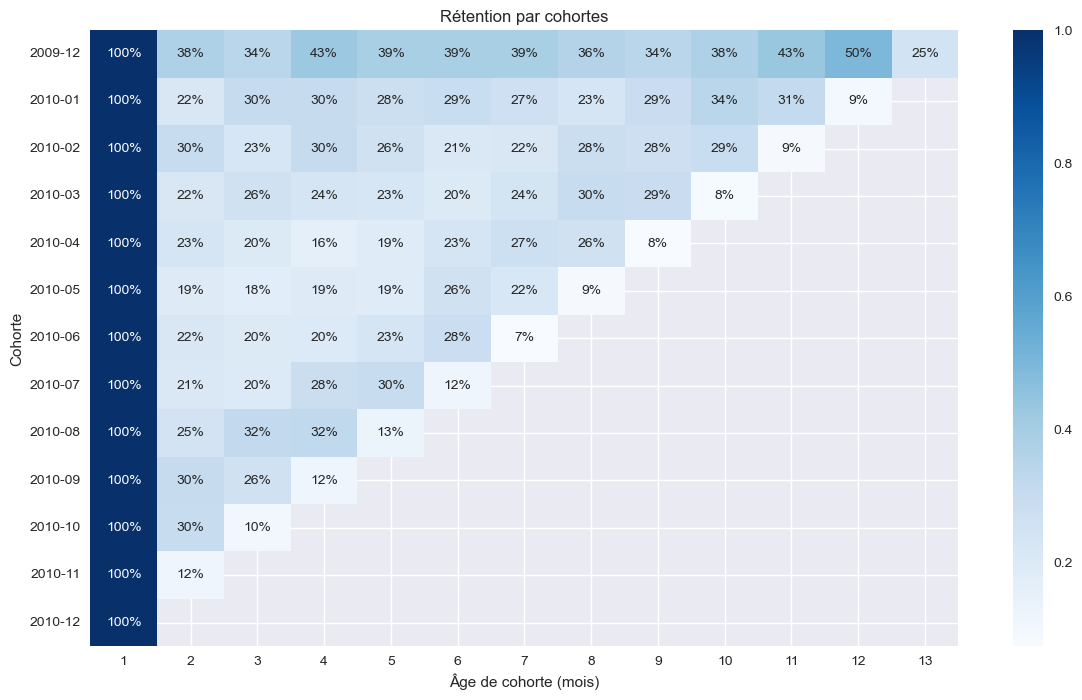

In [27]:
plt.figure(figsize=(14,8))
sns.heatmap(cohort_retention, cmap="Blues", annot=True, fmt=".0%", cbar=True)
plt.title("Rétention par cohortes")
plt.xlabel("Âge de cohorte (mois)")
plt.ylabel("Cohorte")
plt.show()

PARTIE 2 — Analyse du revenu par cohorte
### Revenus par âge de cohorte

Cette vue permet d’identifier :
- les cohortes à forte valeur,
- les décrochages de revenus,
- la dynamique de croissance des cohortes.

In [28]:
cohort_revenue = (
    df_cohort
    .groupby(["Cohort", "CohortIndex"])["AmountAbs"]
    .sum()
    .unstack()
)

cohort_revenue


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort,,,,,,,,,,,,,
2009-12,706882.920,426132.811,317596.012,400566.760,330279.70,346781.56,322637.86,341301.17,349482.530,451166.83,521326.81,612855.092,198232.95
2010-01,155036.021,38376.851,52014.750,58737.721,56497.37,58810.97,48796.23,47333.60,56846.891,88577.43,83926.77,14840.910,NaN
2010-02,165548.623,31975.060,54627.500,51062.850,44407.05,37908.61,41926.68,46583.63,52095.690,54504.22,9528.15,NaN,NaN
2010-03,275981.061,47035.230,54746.600,73207.750,47155.19,54253.76,61755.01,74537.23,69169.170,14098.71,NaN,NaN,NaN
2010-04,135276.021,18572.300,19008.220,31977.970,20843.39,31804.71,31997.25,30018.72,4390.180,NaN,NaN,NaN,NaN
2010-05,110132.690,15285.070,13949.870,12877.410,17135.91,31566.02,22271.41,4872.46,NaN,NaN,NaN,NaN,NaN
2010-06,170600.790,20087.310,22771.620,24708.600,32749.12,48124.54,9784.95,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,77410.660,9142.930,13972.890,23950.480,28411.49,6842.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,60557.820,14118.490,23331.350,23691.810,8181.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


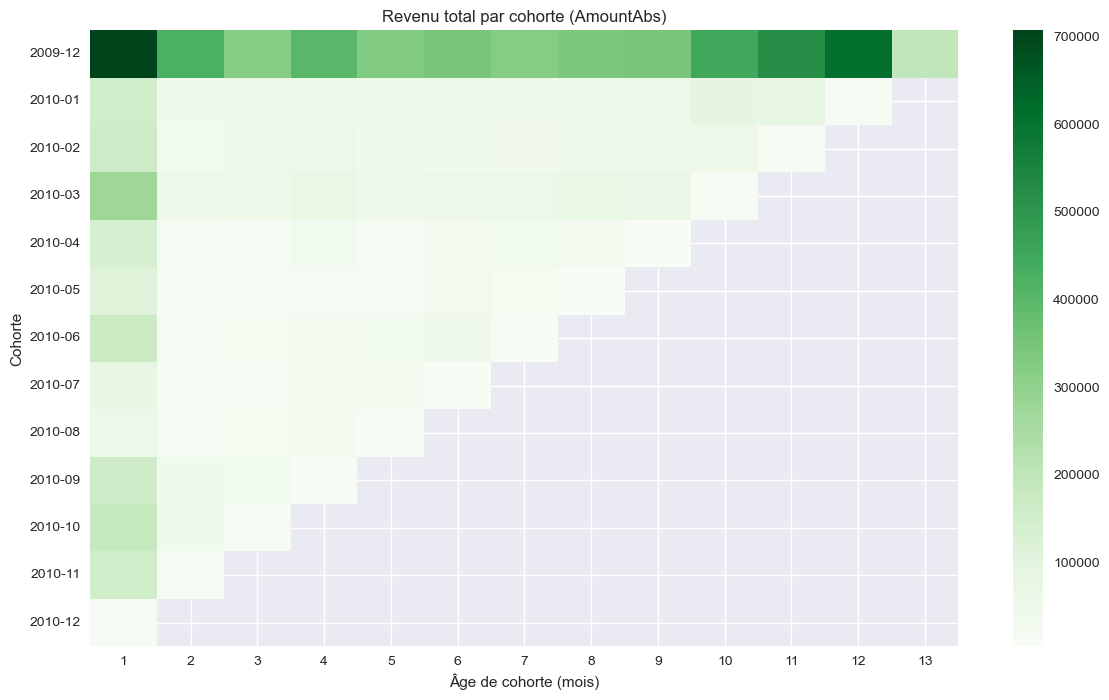

In [29]:
plt.figure(figsize=(14,8))
sns.heatmap(cohort_revenue, cmap="Greens", cbar=True)
plt.title("Revenu total par cohorte (AmountAbs)")
plt.xlabel("Âge de cohorte (mois)")
plt.ylabel("Cohorte")
plt.show()


PARTIE 3 — Courbes de densité (CA moyen par âge)
###  Courbes de densité du CA par âge de cohorte

Ces courbes montrent comment évolue le revenu moyen à chaque âge.


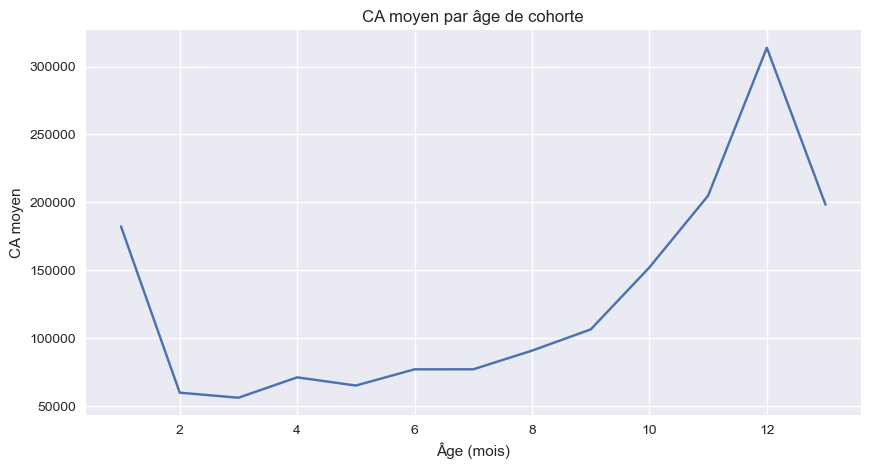

In [30]:
avg_revenue_by_age = cohort_revenue.mean(axis=0)

plt.figure(figsize=(10,5))
plt.plot(avg_revenue_by_age.index, avg_revenue_by_age.values)
plt.title("CA moyen par âge de cohorte")
plt.xlabel("Âge (mois)")
plt.ylabel("CA moyen")
plt.grid(True)
plt.show()


PARTIE 4 — Focus sur une cohorte
###  Focus sur une cohorte spécifique

Utile pour l'équipe marketing :
- comprendre la valeur d’une cohorte précise,
- comparer différentes générations de clients.


Cellule 8 — Sélection dynamique de cohorte

In [31]:
cohort_example = "2010-01"   # tu peux changer la valeur

df_focus = df_cohort[df_cohort["Cohort"] == cohort_example]

df_focus.groupby("CohortIndex")["Customer ID"].nunique()


CohortIndex
1     394
2      86
3     119
4     120
5     110
6     115
7     105
8      91
9     114
10    134
11    122
12     37
Name: Customer ID, dtype: int64

PARTIE 1 — Préparation du RFM
##  Segmentation RFM (Recency – Frequency – Monetary)

L’objectif du RFM est de mesurer :
- **Recency** : ancienneté du dernier achat,
- **Frequency** : fréquence d’achat,
- **Monetary** : montant total dépensé.

La segmentation RFM permet d’identifier les meilleurs clients et ceux à risque.


In [32]:
# Date de référence = dernière date du dataset
ref_date = df_clean["InvoiceDate"].max()

rfm = (
    df_clean
    .groupby("Customer ID")
    .agg({
        "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
        "Invoice": "nunique",                               # Frequency
        "AmountAbs": "sum"                                  # Monetary
    })
    .rename(columns={
        "InvoiceDate": "Recency",
        "Invoice": "Frequency",
        "AmountAbs": "Monetary"
    })
)
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,66,15,797.46
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,4,2695.29
12351.0,10,1,300.93


PARTIE 2 — Scoring de R, F, M
On attribue un score de 1 à 4

In [33]:
# Recency : plus c'est petit, mieux c'est → on garde comme avant
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])

# Frequency : on applique qcut sur le rang pour éviter les doublons de bords
rfm["F_score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    4,
    labels=[1, 2, 3, 4]
)

# Monetary : pareil, on utilise le rang
rfm["M_score"] = pd.qcut(
    rfm["Monetary"].rank(method="first"),
    4,
    labels=[1, 2, 3, 4]
)

# Score global RFM concaténé
rfm["RFM_score"] = (
    rfm["R_score"].astype(str)
    + rfm["F_score"].astype(str)
    + rfm["M_score"].astype(str)
)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
Customer ID,,,,,,,
12346.0,66,15,797.46,2,4,3,243
12347.0,2,2,1323.32,4,2,3,423
12348.0,73,1,222.16,2,1,1,211
12349.0,42,4,2695.29,3,3,4,334
12351.0,10,1,300.93,4,1,1,411


PARTIE 3 — Mapping des segments RFM
###  Attribution des segments RFM

Nous regroupons les scores RFM en segments compréhensibles :
- Champions
- Loyaux
- À risque
- Endormis
- Nouveaux clients
- Potentiel
- Perdus


In [34]:
def rfm_segment(row):
    r, f, m = int(row["R_score"]), int(row["F_score"]), int(row["M_score"])
    
    # Champions : très récents, très fréquents, dépensent beaucoup
    if r == 4 and f == 4:
        return "Champions"
    
    # Loyal : reviennent souvent, bonnes dépenses
    if f == 4 and r >= 2:
        return "Loyaux"
    
    # Potentiel : récents mais pas encore fréquents
    if r == 4 and f <= 2:
        return "Potentiel"
    
    # À risque : vieux clients mais très actifs auparavant
    if r <= 2 and f == 4:
        return "À risque"
    
    # Endormis : vieux et peu fréquents
    if r == 1 and f <= 2:
        return "Endormis"
    
    # Perdus : recency très mauvaise
    if r == 1:
        return "Perdus"
    
    return "Autres"

rfm["Segment"] = rfm.apply(rfm_segment, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
Customer ID,,,,,,,,
12346.0,66,15,797.46,2,4,3,243,Loyaux
12347.0,2,2,1323.32,4,2,3,423,Potentiel
12348.0,73,1,222.16,2,1,1,211,Autres
12349.0,42,4,2695.29,3,3,4,334,Autres
12351.0,10,1,300.93,4,1,1,411,Potentiel


PARTIE 4 — Table RFM finale
Cellule 4

In [35]:
rfm_summary = (
    rfm.groupby("Segment")
    .agg({
        "Frequency": "mean",
        "Monetary": "mean",
        "Recency": "mean",
        "Segment": "count"
    })
    .rename(columns={"Segment": "nb_clients"})
    .sort_values("nb_clients", ascending=False)
)

rfm_summary


,Frequency,Monetary,Recency,nb_clients
Segment,,,,
Autres,2.810379,909.459032,51.931637,2004
Endormis,1.325817,467.664446,250.674183,887
Champions,17.809199,8220.463196,6.345826,587
Loyaux,10.662366,3822.370759,48.234409,465
Potentiel,1.668067,531.183655,9.117647,238
Perdus,3.860759,1191.873354,207.689873,158
À risque,8.181818,2879.219091,196.454545,44


PARTIE 5 — Graphiques RFM
###  Visualisation des segments RFM


Cellule 5 — Barplot nb clients / segment

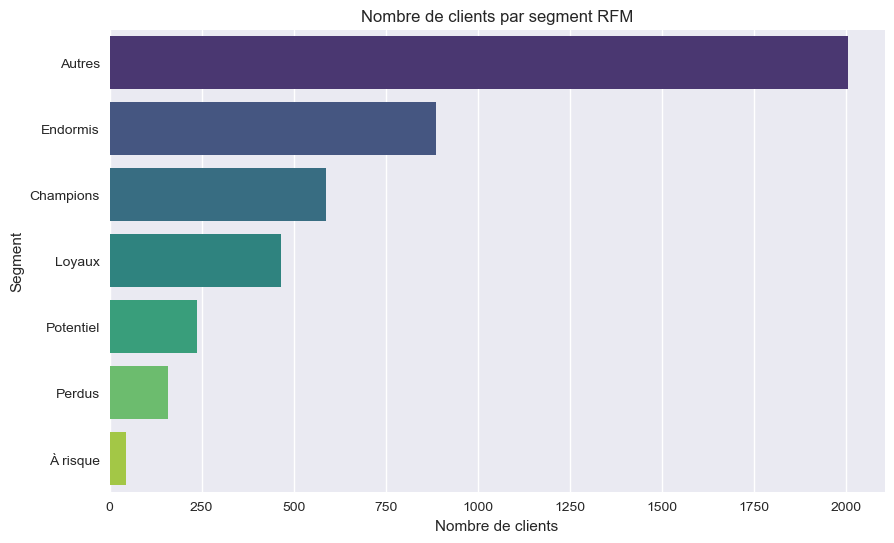

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(
    y=rfm_summary.index,
    x=rfm_summary["nb_clients"],
    palette="viridis"
)
plt.title("Nombre de clients par segment RFM")
plt.xlabel("Nombre de clients")
plt.ylabel("Segment")
plt.show()


PARTIE 1 — CLV EMPIRIQUE (basée sur les cohortes)
Étape 1 : calculer le revenu moyen par client à chaque âge

Chaque ligne = cohorte
Chaque colonne = âge
Valeur = revenu moyen par client restant

Tu vas maintenant ajouter ce Markdown + code.

## CLV empirique (basée sur les cohortes)

La Customer Lifetime Value empirique se calcule comme la somme du revenu moyen
par âge de cohorte (M+0, M+1, ..., M+n).

C’est une estimation basée sur les données réelles observées.


In [37]:
# Revenus totaux par cohorte et âge
cohort_revenue = (
    df_cohort
    .groupby(["Cohort", "CohortIndex"])["AmountAbs"]
    .sum()
    .unstack()
)

# Nombre de clients dans chaque cohorte
cohort_sizes = cohort_counts.iloc[:,0]

# Revenu moyen par client
cohort_avg_revenue = cohort_revenue.divide(cohort_sizes, axis=0).round(2)

cohort_avg_revenue.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort,,,,,,,,,,,,,
2009-12,676.44,407.78,303.92,383.32,316.06,331.85,308.74,326.60,334.43,431.74,498.88,586.46,189.7
2010-01,393.49,97.40,132.02,149.08,143.39,149.27,123.85,120.14,144.28,224.82,213.01,37.67,NaN
2010-02,456.06,88.09,150.49,140.67,122.33,104.43,115.50,128.33,143.51,150.15,26.25,NaN,NaN
2010-03,632.98,107.88,125.57,167.91,108.15,124.44,141.64,170.96,158.64,32.34,NaN,NaN,NaN
2010-04,464.87,63.82,65.32,109.89,71.63,109.29,109.96,103.16,15.09,NaN,NaN,NaN,NaN


Étape 2 — CLV empirique globale
On fait la moyenne entre cohortes
puis on additionne les valeurs par âge
Cellule 2 — CLV empirique globale

In [38]:
avg_revenue_per_age = cohort_avg_revenue.mean(axis=0)

CLV_empirique = avg_revenue_per_age.sum().round(2)
CLV_empirique


2533.38

###  Interprétation de la CLV empirique

La CLV empirique représente la valeur moyenne récupérée par client sur toute sa durée de vie observée.
Elle est basée directement sur les cohortes réelles.

C'est cette CLV qui servira de **baseline** dans l’application Streamlit :
- comparaison de scénarios,
- impact des remises,
- impact d’une baisse/hausse de rétention,
- campagnes marketing.


Étape 3 — Graphique CLV empirique (courbe cumulée)

Cellule 3

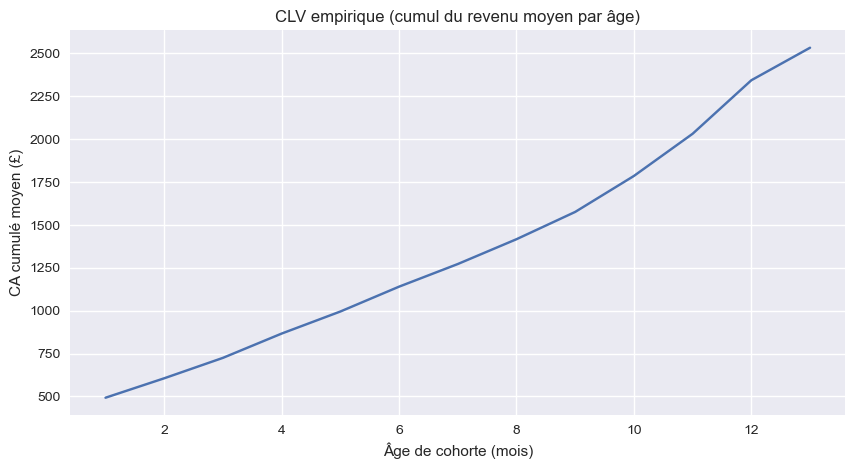

In [39]:
plt.figure(figsize=(10,5))
plt.plot(avg_revenue_per_age.index, avg_revenue_per_age.cumsum())
plt.title("CLV empirique (cumul du revenu moyen par âge)")
plt.xlabel("Âge de cohorte (mois)")
plt.ylabel("CA cumulé moyen (£)")
plt.grid(True)
plt.show()


PARTIE 2 — CLV FORMULE FERMÉE

Étape 4 — Préparation des inputs pour la CLV formule fermée

##  CLV (formule fermée)

La CLV peut également être estimée via une formule analytique :

CLV = (m × r) / (1 + d − r)

Cette version sera utilisée dans Streamlit pour les scénarios.


In [40]:
# Rétention moyenne (hors M0)
retention_rates = cohort_retention.iloc[:,1:].mean().mean()
retention_rates

0.2553991372053872

Cellule 5 — Marge moyenne (m)
On suppose un taux de marge de 30 % (tu pourras le mettre en slider dans Streamlit).

In [41]:
taux_marge = 0.30
marge_moyenne = rfm["Monetary"].mean() * taux_marge
marge_moyenne


635.291711430527

Cellule 6 — CLV formule fermée

In [42]:
r = retention_rates
d = 0.01  # taux discount par défaut

CLV_formule = (marge_moyenne * r) / (1 + d - r)
CLV_formule


215.01824735820958

###  Interprétation de la CLV formule fermée

La formule fermée donne une estimation théorique de la valeur client,
basée sur les hypothèses :

- marge moyenne (m),
- rétention (r),
- taux d’actualisation (d).

Elle permet de tester des scénarios dans Streamlit.


##  Export des données pour l'application Streamlit

Nous sauvegardons ici les tables nettoyées et agrégées nécessaires à l'application :
- df_clean : transactions propres
- rfm : table RFM avec segments
- cohort_retention : matrice de rétention
- cohort_avg_revenue : revenu moyen par âge de cohorte


In [43]:
from pathlib import Path

processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# --- Correction pour Parquet ---
# Convertir les colonnes 'object' en string propre
df_clean = df_clean.astype({
    "Invoice": "string",
    "StockCode": "string",
    "Description": "string",
    "Country": "string"
})

# 1. Transactions nettoyées
df_clean.to_parquet(processed_dir / "online_retail_clean.parquet", index=False)

# 2. Table RFM complète
rfm.to_csv(processed_dir / "rfm_segments.csv")

# 3. Rétention par cohorte
cohort_retention.to_csv(processed_dir / "cohort_retention.csv")

# 4. Revenu moyen par âge de cohorte
cohort_avg_revenue.to_csv(processed_dir / "cohort_avg_revenue.csv")

print(" Fichiers exportés dans data/processed")


 Fichiers exportés dans data/processed


In [44]:
df_clean.dtypes


Invoice                  string[python]
StockCode                string[python]
Description              string[python]
Quantity                          int64
InvoiceDate              datetime64[ns]
Price                           float64
Customer ID                     float64
Country                  string[python]
Amount                          float64
Month                            object
IsReturn                           bool
CohortMonth                   period[M]
CustomerFirstPurchase         period[M]
AmountAbs                       float64
InvoiceYear                       int32
InvoiceMonth                      int32
InvoiceDay                        int32
InvoiceMonthStr                  object
Cohort                           object
CohortIndex                       int64
dtype: object